In [43]:
# Import Library
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import cv2 
import os
import numpy as np
import scipy
from skimage import color, data, restoration
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from random import uniform
from tensorflow.keras.layers import BatchNormalization

In [44]:
# #Load Image

# images = []
# folder = "./Data/Images"
# for filename in os.listdir(folder):
#     img = cv2.imread(os.path.join(folder,filename))
#     if img is not None:
#         images.append(img)
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [45]:
# (train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
ClassifiedDataDir = "./Data/ClassifiedData/Train"
BATCH_SIZE = 32 
IMG_SIZE = (128, 128)
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory = ClassifiedDataDir,
        labels='inferred',
        label_mode='int',
        class_names=None,
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        shuffle=True,
        seed=1337,
        subset="training",
        validation_split=0.1,
        interpolation='bilinear',
        follow_links=False,
        crop_to_aspect_ratio=False,
        # rescale = 1./255,
    )
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    directory = ClassifiedDataDir,
        labels='inferred',
        label_mode='int',
        class_names=None,
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        shuffle=True,
        seed=1337,
        subset="validation",
        validation_split=0.1,
        interpolation='bilinear',
        follow_links=False,
        crop_to_aspect_ratio=False,
        # rescale = 1./255,
    )

    
test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory = "./Data/ClassifiedData/Test",
        labels='inferred',
        label_mode='int',
        class_names=None,
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        shuffle=True,
        seed=None,
        interpolation='bilinear',
        follow_links=False,
        crop_to_aspect_ratio=False,
        # rescale = 1./255,
    )

Found 3525 files belonging to 24 classes.
Using 3173 files for training.
Found 3525 files belonging to 24 classes.
Using 352 files for validation.
Found 312 files belonging to 24 classes.
Using 31 files for validation.


In [46]:
# for element in dataset.as_numpy_iterator():
#     print(element)
class_names = train_dataset.class_names
print(class_names)
print(len(class_names))

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
24


In [47]:
# print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset).numpy())
# print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset).numpy())

In [48]:
# DataSet
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [49]:
# # # Model 1 Initialize
# input_size = 128
# filter_size = 14
# num_filter = 8
# maxpool_size = 2
# batch_size = BATCH_SIZE
# epochs = 30

# model = tf.keras.models.Sequential([
#     tf.keras.layers.InputLayer(input_shape=(input_size, input_size, 3)),
#     tf.keras.layers.Reshape((256, 256 * 3)),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM( 256, return_sequences=True, return_state=False )),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM( 256 )),
#     tf.keras.layers.Dense( 256 ),
#     tf.keras.layers.Dropout(.2),
#     tf.keras.layers.Dense( 256 ),
# ])

# # model = models.Sequential()
# # model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(input_size, input_size, 3)))
# # model.add(layers.MaxPooling2D((2, 2)))
# # model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# # model.add(layers.MaxPooling2D((2, 2)))
# # model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# model.add(tf.keras.layers.Flatten())
# # model.add(tf.keras.layers.Dense(24))
# model.add(tf.keras.layers.Dense(24, activation = 'softmax'))

# # model.add(layers.Flatten())
# # model.add(layers.Dense(64, activation='relu'))
# # model.add(layers.Dense(24))

# model.summary()



In [50]:
# # Optimizer
# optimizer = tf.keras.optimizers.Nadam(
#     learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,
#     name='Nadam'
# ) # 0.00001

# # Loss Fn
# lossfn = tf.keras.losses.SparseCategoricalCrossentropy( from_logits=False, reduction=tf.keras.losses.Reduction.AUTO, name='sparse_categorical_crossentropy')

# # Model Summary
# model.compile(
#     optimizer="rmsprop",
#     loss="sparse_categorical_crossentropy",
#     metrics=["sparse_categorical_accuracy"],
# )

In [51]:
# Model 2

input_size = 128
filter_size = 3
num_filter = 8
maxpool_size = 2
batch_size = BATCH_SIZE
epochs = 30

steps_per_epoch = 24720/batch_size

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(16, (filter_size,filter_size), 
                 input_shape= (input_size,input_size,3), 
                 activation ='relu',
                 padding='same'))
model.add(tf.keras.layers.Conv2D(16, (filter_size,filter_size), 
                 input_shape= (input_size,input_size,3), 
                 activation ='relu',
                 padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(maxpool_size, maxpool_size),strides=1))
model.add(tf.keras.layers.Dropout(uniform(0, 1)))

model.add(tf.keras.layers.Conv2D(32, (filter_size,filter_size), 
                 activation='relu', 
                 padding='valid'))
model.add(tf.keras.layers.Conv2D(32, (filter_size,filter_size), 
                 activation='relu', 
                 padding='valid'))
model.add(BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(maxpool_size, maxpool_size),strides=2))
model.add(tf.keras.layers.Dropout(uniform(0, 1)))  

model.add(tf.keras.layers.Conv2D(32, (filter_size,filter_size), 
                 activation='relu', 
                 padding='valid'))
model.add(tf.keras.layers.Conv2D(32, (filter_size,filter_size), 
                 activation='relu', 
                 padding='valid'))
model.add(BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(maxpool_size, maxpool_size),strides=2))
model.add(tf.keras.layers.Dropout(uniform(0, 1)))  

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(120, activation='relu'))
model.add(tf.keras.layers.Dense(24,activation='softmax'))


In [52]:
METRICS = [ 'accuracy']#, 'precision','recall']
model.compile( optimizer= tf.keras.optimizers.Adam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=METRICS)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 conv2d_18 (Conv2D)          (None, 128, 128, 16)      2320      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 127, 127, 16)      0         
                                                                 
 conv2d_19 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 conv2d_20 (Conv2D)          (None, 123, 123, 32)      9248      
                                                      

c:\Users\ZEPHYRUS GU502GU\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [53]:
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU')) 
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [54]:
# Training
history = model.fit(    
    train_dataset,
    epochs=30,
    validation_data = (validation_dataset)
    )


Epoch 1/30
100/100 [==============================] - 9s 72ms/step - loss: 3.0011 - accuracy: 0.3536 - val_loss: 2.6748 - val_accuracy: 0.3011
Epoch 2/30
100/100 [==============================] - 7s 64ms/step - loss: 0.7472 - accuracy: 0.7602 - val_loss: 2.2979 - val_accuracy: 0.4091
Epoch 3/30
100/100 [==============================] - 7s 65ms/step - loss: 0.2783 - accuracy: 0.9162 - val_loss: 3.0288 - val_accuracy: 0.4290
Epoch 4/30
100/100 [==============================] - 7s 70ms/step - loss: 0.1498 - accuracy: 0.9537 - val_loss: 0.9652 - val_accuracy: 0.7045
Epoch 5/30
100/100 [==============================] - 8s 78ms/step - loss: 0.1033 - accuracy: 0.9653 - val_loss: 0.1061 - val_accuracy: 0.9716
Epoch 6/30
100/100 [==============================] - 7s 69ms/step - loss: 0.0615 - accuracy: 0.9839 - val_loss: 7.2646 - val_accuracy: 0.2415
Epoch 7/30
100/100 [==============================] - 7s 71ms/step - loss: 0.0685 - accuracy: 0.9789 - val_loss: 0.1638 - val_accuracy: 0.9631

In [55]:
loss, acc = model.evaluate(test_dataset)
print(loss, acc)

1/1 [==============================] - 0s 460ms/step - loss: 0.0010 - accuracy: 1.0000
0.0010410936083644629 1.0


In [56]:
loss, acc = model.evaluate(validation_dataset)
print(loss, acc)

11/11 [==============================] - 1s 22ms/step - loss: 0.1032 - accuracy: 0.9716
0.10321157425642014 0.9715909361839294


In [57]:
# model.save('saved_model/model3UsingHandsignTopology')

In [58]:
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

Restored model, accuracy: 97.16%


In [59]:
# # class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
# #                'dog', 'frog', 'horse', 'ship', 'truck']

# plt.figure(figsize=(10,10))
# for i in range(25):
#     plt.subplot(5,5,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     plt.imshow(train_images[i])
#     # The CIFAR labels happen to be arrays, 
#     # which is why you need the extra index
#     plt.xlabel(class_names[train_labels[i][0]])
# plt.show()

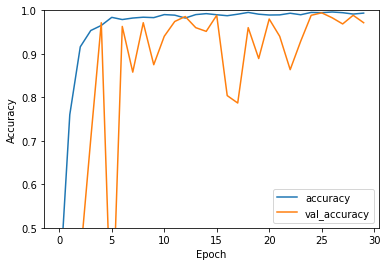

In [60]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [61]:
# print(test_acc)